# 1. Import Dependencies

In [114]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import matplotlib.patheffects as PathEffects
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from neural_network_classes import LSTM, DARNN

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
timesteps = 10 # lookback window
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

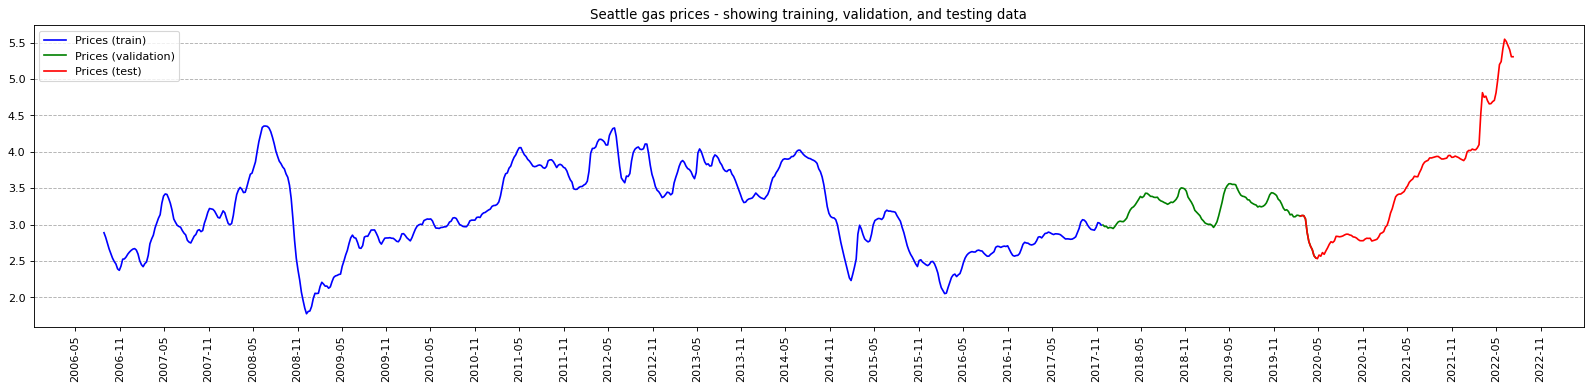

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 6. Modeling

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, target_scaler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                y_pred, alpha, beta = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, batch_y_h, h, c)
                elif model_name == 'darnn':
                    output, alpha, beta = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
#             preds = preds*(target_train_max - target_train_min) + target_train_min
#             true = true*(target_train_max - target_train_min) + target_train_min
            preds = target_scaler.inverse_transform(preds)
            true = target_scaler.inverse_transform(true)
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(12, 6))
            plt.plot(preds, label='predicted')
            plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
            plt.legend(loc="upper left")
            plt.title(f'Validation Results for Epoch {i}')
            plt.show()
    return

In [138]:
def nn_eval(model, model_name, data_test_loader, target_scaler):
    
    with torch.no_grad():
        mse_val = 0
        loss = nn.MSELoss()
        preds = []
        true = []
        alphas = []
        betas = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                output, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                output, alpha, beta = model(batch_x, batch_y_h)
                alphas.append(alpha.detach().cpu().numpy())
                betas.append(beta.detach().cpu().numpy())
                
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    if model_name == 'darnn':
        alphas = np.concatenate(alphas)
        betas = np.concatenate(betas)
    
    # De-normalize
    preds = target_scaler.inverse_transform(preds)
    true = target_scaler.inverse_transform(true)
    
    # Collect results
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pcc, _ = PCC(true, preds)  
    err = true - preds
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(preds, label='preds')
    plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
    plt.legend(loc="upper left")
    plt.title(f'Test Results for {model_name.upper()} Model', fontsize=15)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Seattle Gas Price', fontsize=12)
    plt.show()
    
    # Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(ax=ax, x=true, y=preds)
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predictions', fontsize=12)
    ax.set_title(f'Test Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc:.3f}', fontsize=15)
    ax.set_aspect('equal', 'box')
    
    # Error Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ax=ax, data=err, kde=True)
    ax.set_xlabel('Prediction Errors (U.S. $)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Model Testing Prediction Errors \n MSE = {mse:.3f} \n MAE = {mae:.3f}', fontsize=15)
    
    # Attention Weights Heatmap
    if model_name == 'darnn':
        alphas = alphas.mean(axis=0)
        betas = betas.mean(axis=0).squeeze()[::-1]

        attn = np.zeros([len(alphas), len(betas)])
        for i in range(len(alphas)):
            for j in range(len(betas)):
                attn[i,j] = (alphas[i] + betas[j]) / 2

        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(attn, cmap='rainbow')
        cols = features_targets.columns[0:-1].tolist()
        ax.set_xticks(np.arange(len(betas)))
        ax.set_yticks(np.arange(len(alphas)))
        ax.set_xticklabels(["t-"+str(i) for i in np.arange(len(betas), 0, -1)])
        ax.set_yticklabels(cols)
        for i in range(len(cols)):
            for j in range(len(betas)):
                val = round(attn[i, j], 3)
                if val < 0.105 and val > 0.07:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="w")
        ax.set_title("DA-RNN Attention Weights:\nImportance of Features and Timesteps")
        cbar = fig.colorbar(im, ax=ax, label='More Important \u2192')
        cbar.set_label(label='\n More Important \u2192',size='12')
        plt.show()
    
    return mse, mae, r2, pcc, preds, true, alphas, betas

In [39]:
def nn_forecast(model, model_name, data, timesteps, n_timeseries, true, preds, x_scaler, y_his_scaler, target_scaler, plot_range=10):

    data = data.to_numpy()
    
    data_x_unseen = data[-timesteps:,:-1]
    y_hist_unseen = data[-timesteps:,-1]
    y_hist_unseen = np.expand_dims(y_hist_unseen, axis=1)
    
    data_x_unseen = x_scaler.transform(data_x_unseen)
    y_hist_unseen = y_his_scaler.transform(y_hist_unseen)
    
    x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0)
    y_hist = torch.tensor(y_hist_unseen).float().to(device).unsqueeze(0)

    model.eval()
    if model_name == 'lstm':
        h0, c0 = model.init_hidden_internal(x.shape[0])
        prediction, h, c = model(x, y_hist, h0, c0)
    elif model_name == 'darnn':
        prediction, alpha, beta = model(x, y_hist)
        
    prediction = prediction.cpu().detach().numpy()

    # prepare plots

    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = true[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = preds[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = target_scaler.inverse_transform(prediction)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    next_week = plot_date_test[-1] + dt.timedelta(days=7)
    plot_date_test.append(next_week)

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color='black')
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10)
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color='red')
    plt.title("Predicted Seattle gas price of the next week")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print(f'{model_name.upper()} Predicted Seattle Gas Price of the next week: ${to_plot_data_y_test_pred[plot_range-1]:.2f}')
    
    return

## 6a. Time Series Model (Neural Prophet)

### Training

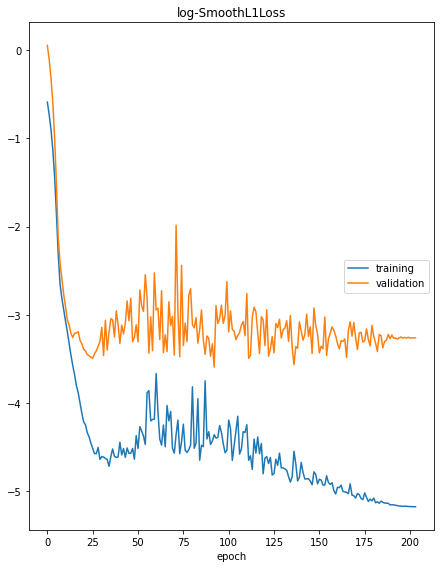

log-SmoothL1Loss
	training         	 (min:   -5.177, max:   -0.588, cur:   -5.177)
	validation       	 (min:   -3.592, max:    0.054, cur:   -3.263)


In [40]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [41]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005645,0.197299,0.259716,0.0,0.038291,0.580631,0.701798


### Evaluation

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.038  0.581  0.702


   SmoothL1Loss       MAE      RMSE
0      0.038291  0.580631  0.701798


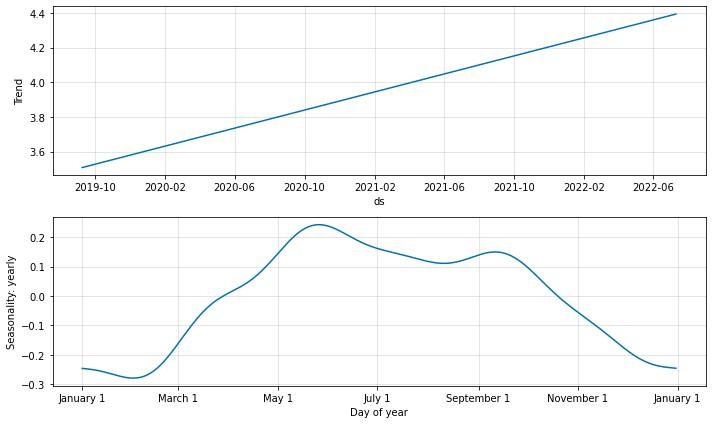

In [42]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


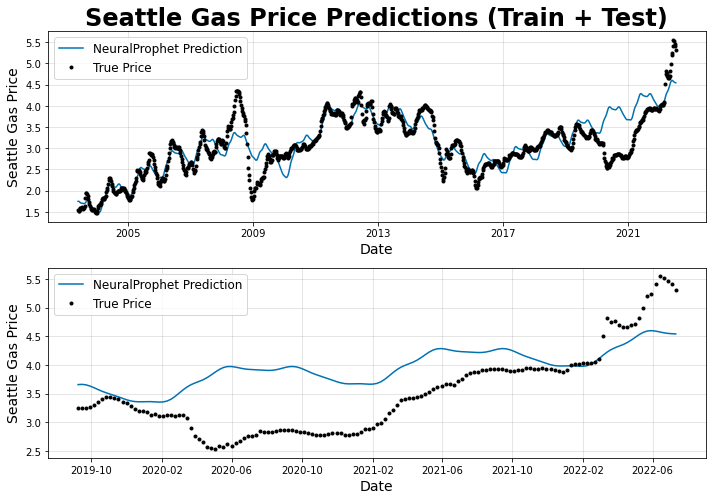

In [43]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

### Forecasting

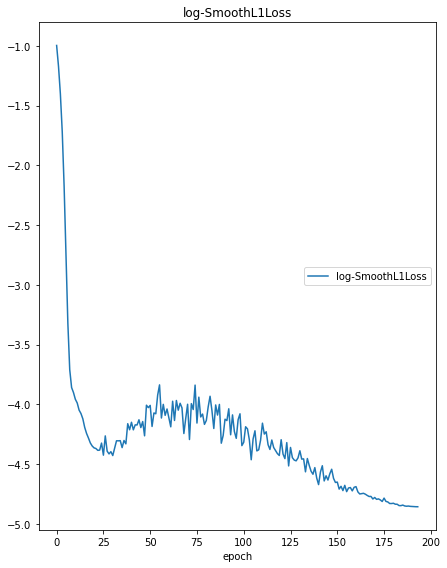

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.856, max:   -0.996, cur:   -4.856)


In [44]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


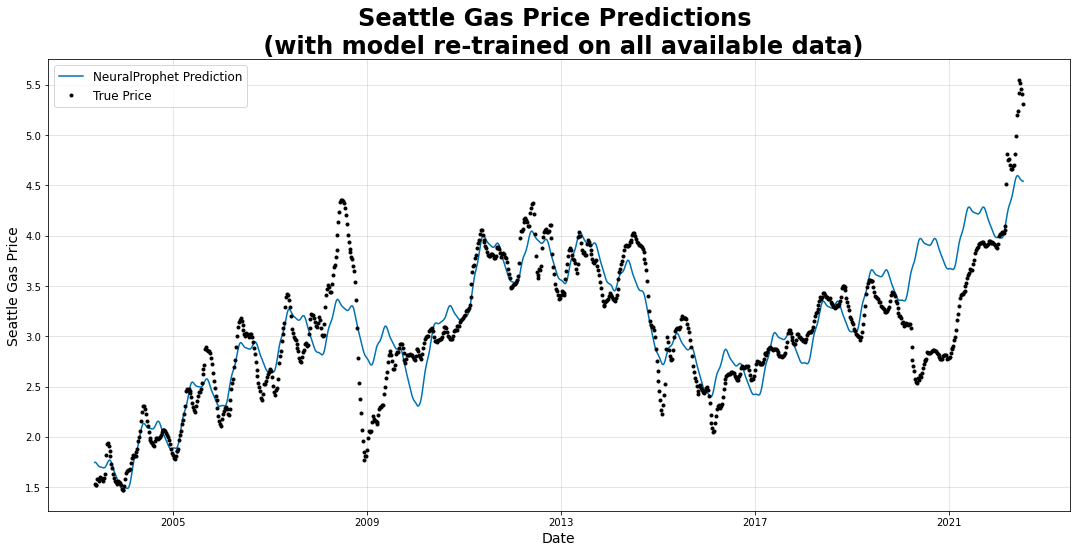

In [45]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [46]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

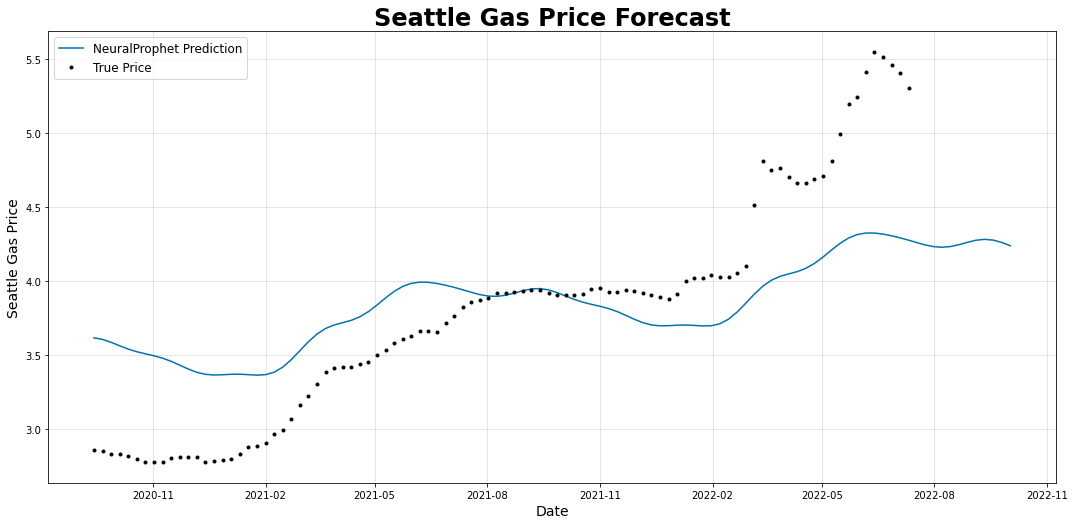

In [47]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

### Training

In [48]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=64, num_layers=2, # hidden=64, layers=2
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = torch.optim.Adam(lstm.parameters(), lr=0.01)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.007231).  Saving model ...
Iter:  0 train:  0.23269711340712768 val:  0.08503352385063324 LR:  0.01
mse:  0.048167747 mae:  0.1885202


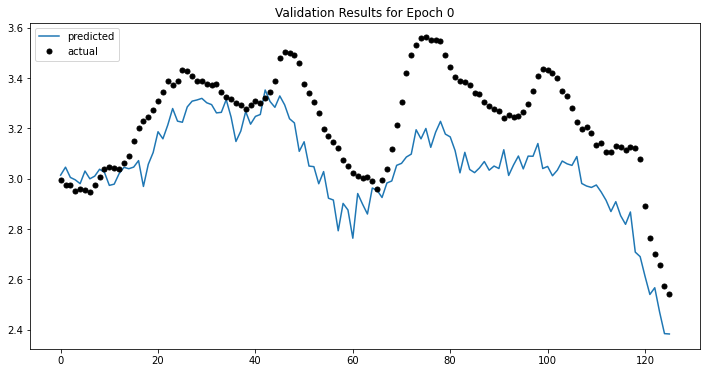

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.06378007332853416 val:  0.10946395342709314 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.05540985416013689 val:  0.11568908620934881 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  3 train:  0.05541777687681738 val:  0.09667681037911705 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  4 train:  0.0469842691284111 val:  0.12183019351907193 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  5 train:  0.04880964668345146 val:  0.11611255622252514 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  6 train:  0.04705628986668642 val:  0.11709412217572611 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  7 train:  0.038899787710543116 val:  0.11308755860138141 LR:  0.01
Validation loss decreased (0.007231 --> 0.004515).  Saving model ...
Iter:  8 train:  0.03966701456630698 val:  0.06719666031351249 LR:  0.01
Validation loss decreased (0.004515 --> 0.003614).  Saving model ...
Iter:  9 train:  0.04507216349524

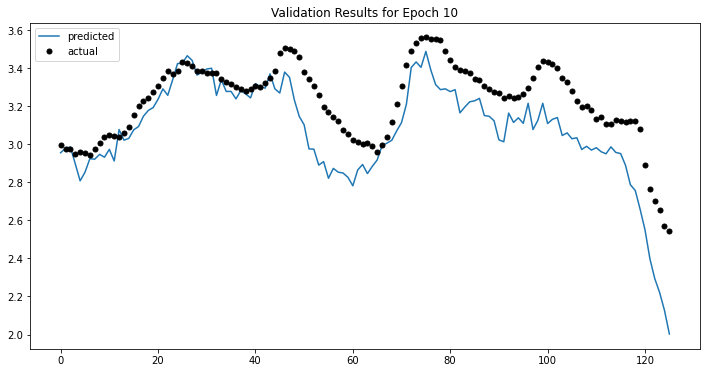

EarlyStopping counter: 2 out of 50
Iter:  11 train:  0.04123167017382874 val:  0.09841651241641594 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  12 train:  0.037074270200066615 val:  0.11100564640064915 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  13 train:  0.03329226584129164 val:  0.0946357502743861 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  14 train:  0.03339334369980259 val:  0.08392502212489694 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  15 train:  0.03262334028193948 val:  0.07784817139844115 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  16 train:  0.031394273398518684 val:  0.09043808851655667 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  17 train:  0.03712344312327288 val:  0.061711459002731055 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  18 train:  0.035879332088898916 val:  0.10593794139462528 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  19 train:  0.02955024605261382 val:  0.09477195048758179 LR:  0.01
EarlyStopping c

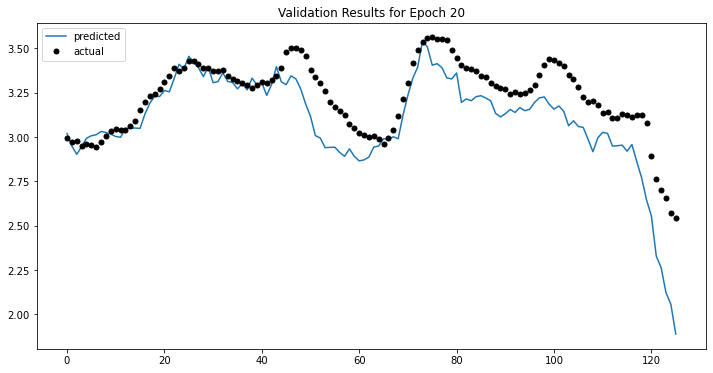

Validation loss decreased (0.003614 --> 0.003501).  Saving model ...
Iter:  21 train:  0.03680356139884944 val:  0.05916820799522058 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  22 train:  0.03232754225987365 val:  0.08888446091702974 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  23 train:  0.03162103865451874 val:  0.07731592823557887 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  24 train:  0.033355147359135834 val:  0.10102420688747972 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  25 train:  0.028321852518478886 val:  0.09329521624104138 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  26 train:  0.02889815704519263 val:  0.08580473242497041 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  27 train:  0.02920904299821721 val:  0.09481048533797465 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  28 train:  0.03079942972845827 val:  0.08538858831764114 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  29 train:  0.026016518487434772 val:  0.0869872844

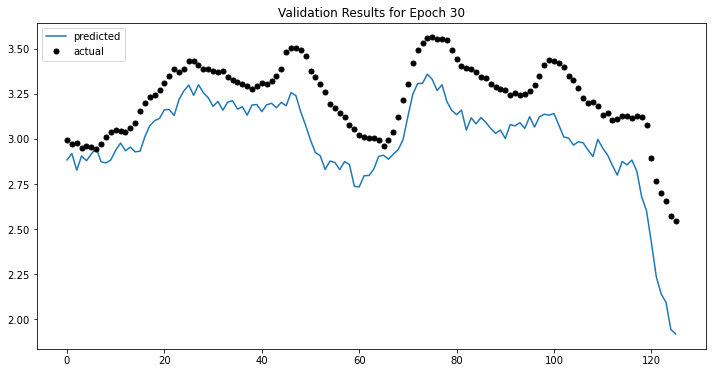

EarlyStopping counter: 10 out of 50
Iter:  31 train:  0.03029737920144818 val:  0.07741918646518088 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  32 train:  0.032530376864700054 val:  0.10536514218953523 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  33 train:  0.027383686518780738 val:  0.08358114150225067 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  34 train:  0.02583981217304321 val:  0.08901752852880819 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  35 train:  0.025607086814007116 val:  0.0733390764688097 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  36 train:  0.02317746013985313 val:  0.07398015545595024 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  37 train:  0.023016504707196104 val:  0.061297607122829174 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  38 train:  0.022426514417670938 val:  0.06782116321530608 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  39 train:  0.020542510102089497 val:  0.06359569280804654 LR:  0.001
E

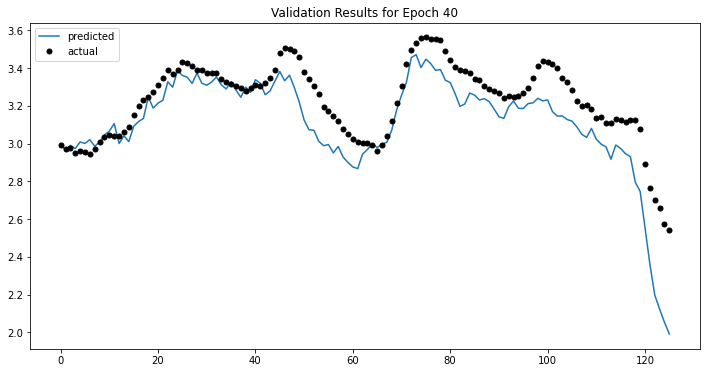

EarlyStopping counter: 20 out of 50
Iter:  41 train:  0.020196784885894156 val:  0.06702408445645036 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  42 train:  0.019653927723429568 val:  0.06085817854874823 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  43 train:  0.020107171579914155 val:  0.06745747386995292 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  44 train:  0.020665115913440606 val:  0.06242990453934286 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  45 train:  0.019819423643599975 val:  0.06177582785313211 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  46 train:  0.019007669530317857 val:  0.06876716887280598 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  47 train:  0.019690126814121515 val:  0.06435699674589264 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  48 train:  0.01986393515573102 val:  0.06151703174713695 LR:  0.001
Validation loss decreased (0.003501 --> 0.003417).  Saving model ...
Iter:  49 train:  0.0192868006784895

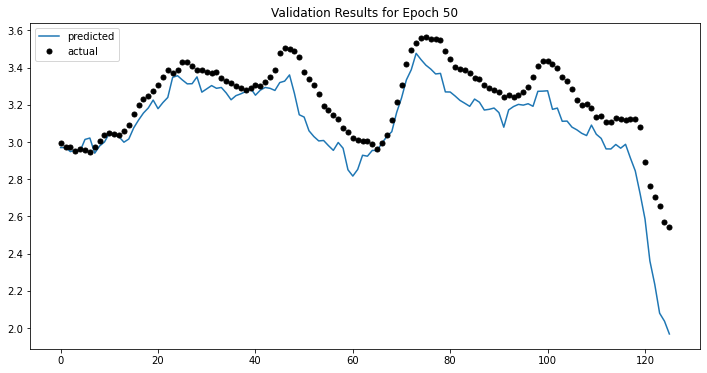

EarlyStopping counter: 2 out of 50
Iter:  51 train:  0.018951904441472774 val:  0.06637710157853462 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  52 train:  0.019096745126197204 val:  0.06474099042662726 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  53 train:  0.018685677573555885 val:  0.06564706878016349 LR:  0.001
Validation loss decreased (0.003417 --> 0.003247).  Saving model ...
Iter:  54 train:  0.01897261115937236 val:  0.05698639782179915 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  55 train:  0.018529664749873324 val:  0.058740890335281765 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  56 train:  0.018994377273305357 val:  0.06224891721544523 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  57 train:  0.01884687511570881 val:  0.06624785087906322 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  58 train:  0.019134983034592976 val:  0.058870835299624016 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  59 train:  0.018924587288676364 val:

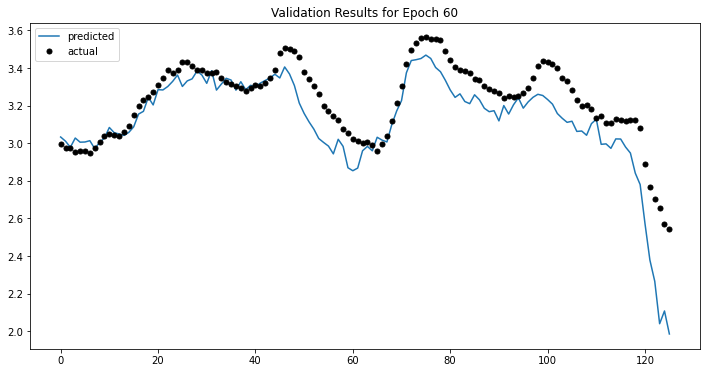

EarlyStopping counter: 7 out of 50
Iter:  61 train:  0.018711213574086807 val:  0.06155612991337953 LR:  0.001
Validation loss decreased (0.003247 --> 0.003231).  Saving model ...
Iter:  62 train:  0.018981420668930323 val:  0.056837538264508394 LR:  0.001
Validation loss decreased (0.003231 --> 0.003163).  Saving model ...
Iter:  63 train:  0.019457729487360936 val:  0.0562375126668391 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  64 train:  0.01825939970867076 val:  0.06494885464640032 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  65 train:  0.017855555071273007 val:  0.059162303950175195 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  66 train:  0.01867879844815357 val:  0.0623750812488155 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  67 train:  0.018662525242470942 val:  0.05965105044769387 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  68 train:  0.018296982750801296 val:  0.06022097251162371 LR:  0.001
EarlyStopping counter: 6 out of 50
Iter:  69 t

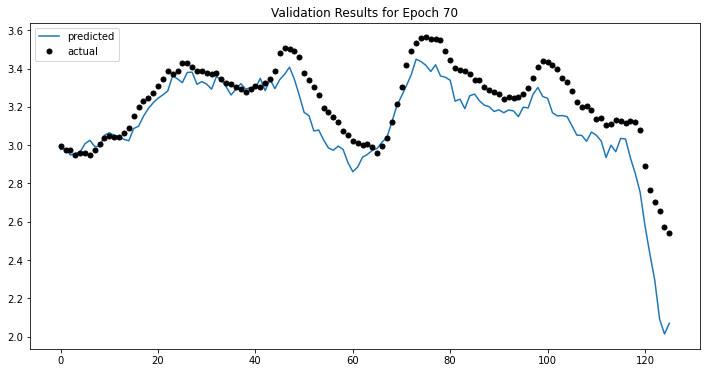

EarlyStopping counter: 8 out of 50
Iter:  71 train:  0.018357404769411008 val:  0.057984444506012194 LR:  0.001
EarlyStopping counter: 9 out of 50
Iter:  72 train:  0.01806030336007975 val:  0.06294782943920023 LR:  0.001
EarlyStopping counter: 10 out of 50
Iter:  73 train:  0.01927251309675318 val:  0.05859928754595639 LR:  0.001
EarlyStopping counter: 11 out of 50
Iter:  74 train:  0.017286368920320518 val:  0.05748433666484887 LR:  0.001
EarlyStopping counter: 12 out of 50
Iter:  75 train:  0.018757662327708802 val:  0.057205184851695415 LR:  0.001
EarlyStopping counter: 13 out of 50
Iter:  76 train:  0.018143975440505996 val:  0.0642591145833002 LR:  0.001
EarlyStopping counter: 14 out of 50
Iter:  77 train:  0.018184797496586906 val:  0.05827241418528815 LR:  0.001
EarlyStopping counter: 15 out of 50
Iter:  78 train:  0.017558052313792146 val:  0.06410626440081713 LR:  0.001
EarlyStopping counter: 16 out of 50
Iter:  79 train:  0.01803655582085716 val:  0.06248334416604425 LR:  0.

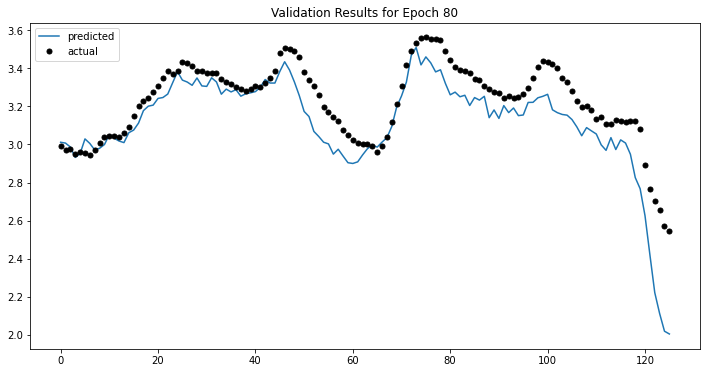

EarlyStopping counter: 18 out of 50
Iter:  81 train:  0.016681704927110755 val:  0.05802622877589137 LR:  0.0001
EarlyStopping counter: 19 out of 50
Iter:  82 train:  0.016578355983535163 val:  0.060719217973259354 LR:  0.0001
EarlyStopping counter: 20 out of 50
Iter:  83 train:  0.018166776227174837 val:  0.058818950941972425 LR:  0.0001
EarlyStopping counter: 21 out of 50
Iter:  84 train:  0.01676881564195383 val:  0.058650654800674225 LR:  0.0001
EarlyStopping counter: 22 out of 50
Iter:  85 train:  0.016724658352423136 val:  0.05979311284022401 LR:  0.0001
EarlyStopping counter: 23 out of 50
Iter:  86 train:  0.016701828207321225 val:  0.059349695102497796 LR:  0.0001
EarlyStopping counter: 24 out of 50
Iter:  87 train:  0.01692274318359918 val:  0.05964499771611829 LR:  0.0001
EarlyStopping counter: 25 out of 50
Iter:  88 train:  0.016950782817730856 val:  0.058852026804691315 LR:  0.0001
EarlyStopping counter: 26 out of 50
Iter:  89 train:  0.01650372966397887 val:  0.05794842665

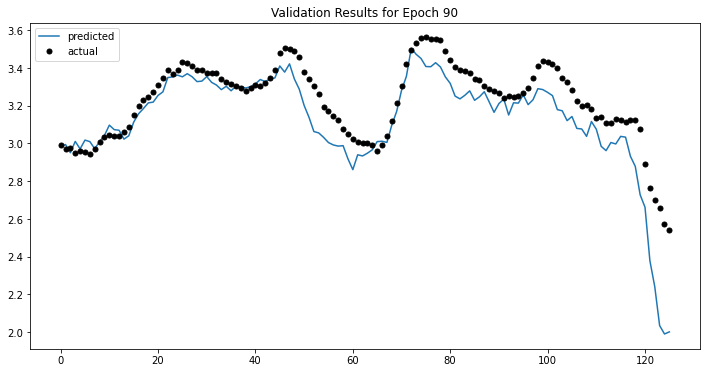

EarlyStopping counter: 28 out of 50
Iter:  91 train:  0.016338637285457137 val:  0.06006985541061115 LR:  0.0001
EarlyStopping counter: 29 out of 50
Iter:  92 train:  0.016668684717875554 val:  0.061630815520400735 LR:  0.0001
EarlyStopping counter: 30 out of 50
Iter:  93 train:  0.01720809337874092 val:  0.058061432271809446 LR:  0.0001
EarlyStopping counter: 31 out of 50
Iter:  94 train:  0.016236378503292924 val:  0.058038371468995896 LR:  0.0001
EarlyStopping counter: 32 out of 50
Iter:  95 train:  0.016675611975504323 val:  0.056571075225437965 LR:  1e-05
EarlyStopping counter: 33 out of 50
Iter:  96 train:  0.015986892761958388 val:  0.05780589479260414 LR:  1e-05
EarlyStopping counter: 34 out of 50
Iter:  97 train:  0.01612793385458461 val:  0.06021091066543374 LR:  1e-05
EarlyStopping counter: 35 out of 50
Iter:  98 train:  0.016958326876235236 val:  0.058880385894274266 LR:  1e-05
EarlyStopping counter: 36 out of 50
Iter:  99 train:  0.01663987311108989 val:  0.059001293476409

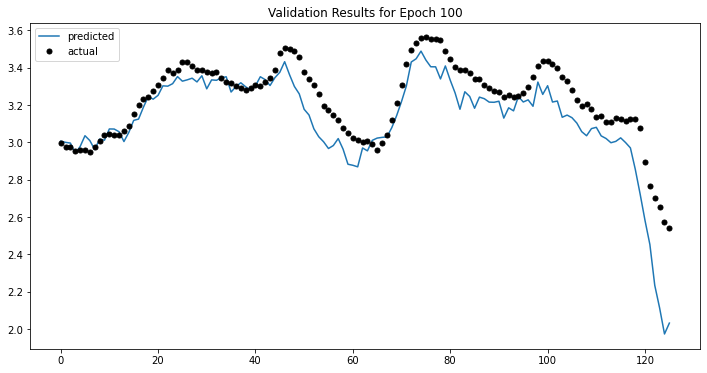

EarlyStopping counter: 38 out of 50
Iter:  101 train:  0.016960689797265897 val:  0.05703273444673619 LR:  1e-05
EarlyStopping counter: 39 out of 50
Iter:  102 train:  0.0174091223939309 val:  0.05737064503734652 LR:  1e-05
EarlyStopping counter: 40 out of 50
Iter:  103 train:  0.01703526291759109 val:  0.05850104007785752 LR:  1e-05
EarlyStopping counter: 41 out of 50
Iter:  104 train:  0.01590602624567965 val:  0.05785526021287302 LR:  1e-05
EarlyStopping counter: 42 out of 50
Iter:  105 train:  0.015821924477310758 val:  0.05707725797082825 LR:  1e-05
EarlyStopping counter: 43 out of 50
Iter:  106 train:  0.017089906307926648 val:  0.05918861455645496 LR:  1e-05
EarlyStopping counter: 44 out of 50
Iter:  107 train:  0.016445610836553114 val:  0.05903555215188216 LR:  1e-05
EarlyStopping counter: 45 out of 50
Iter:  108 train:  0.017034934770517485 val:  0.05898256187440215 LR:  1e-05
EarlyStopping counter: 46 out of 50
Iter:  109 train:  0.01670002026505227 val:  0.05765900381789304

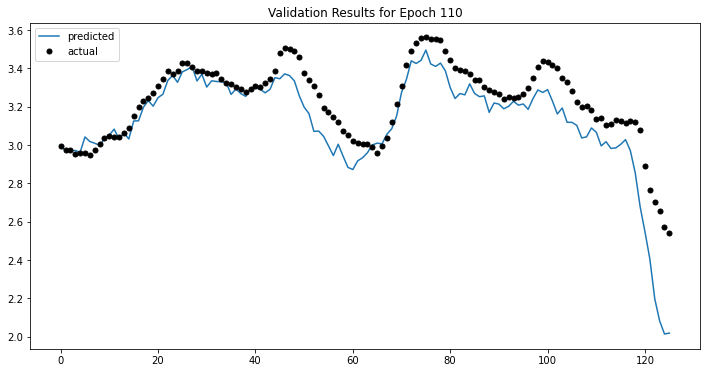

EarlyStopping counter: 48 out of 50
Iter:  111 train:  0.0171341807557593 val:  0.05731339282667642 LR:  1.0000000000000002e-06
EarlyStopping counter: 49 out of 50
Iter:  112 train:  0.016538529814635237 val:  0.05737872947473703 LR:  1.0000000000000002e-06
EarlyStopping counter: 50 out of 50
Early stopping


In [49]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [50]:
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

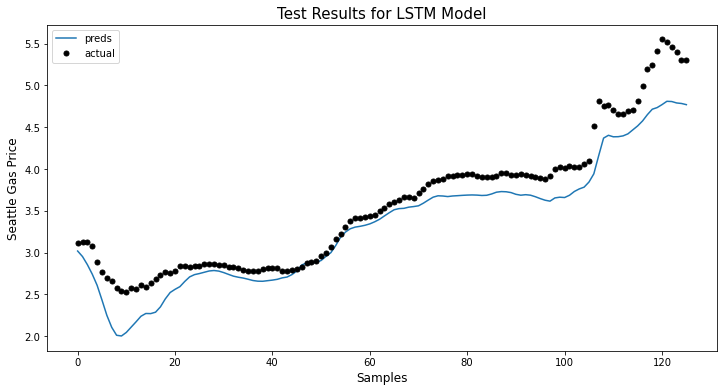

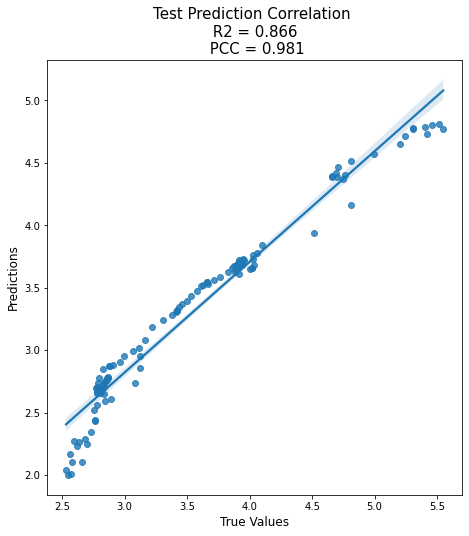

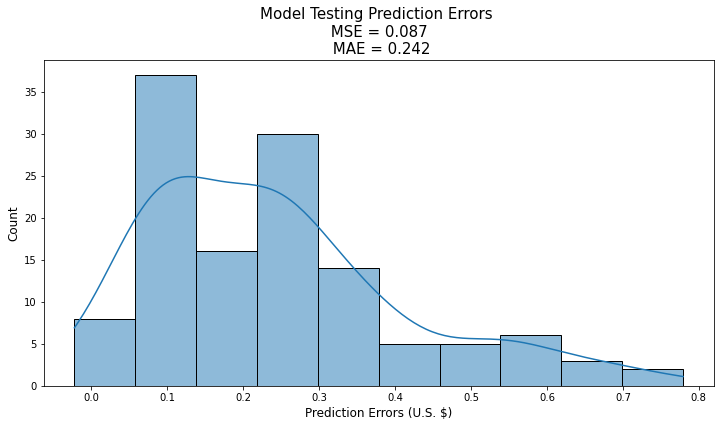

In [139]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true, _, _ = nn_eval(model=lstm, 
                                                                             model_name='lstm', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

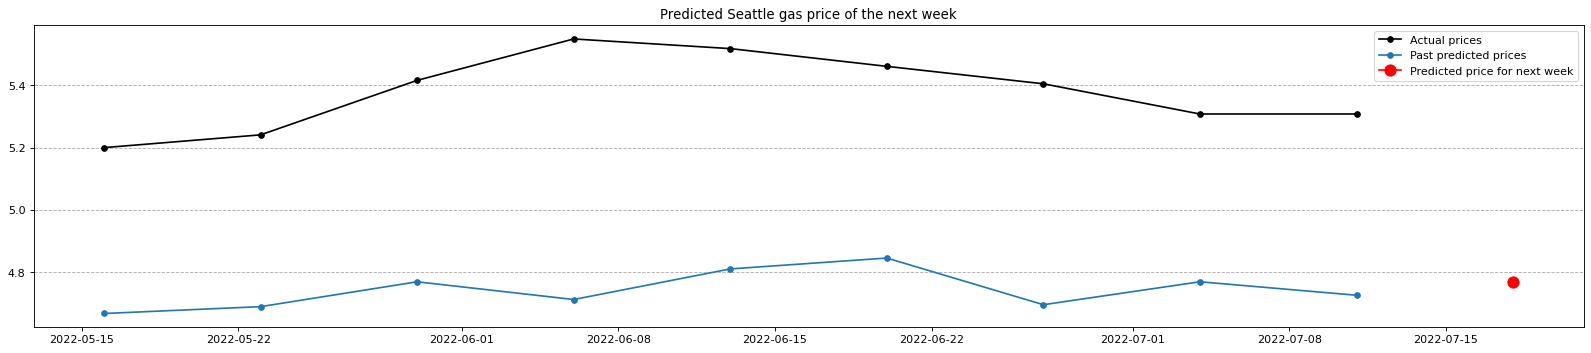

LSTM Predicted Seattle Gas Price of the next week: $4.77


In [52]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6c. Attentioned-Based Neural Network (DA-RNN)

### Training

In [53]:
darnn = DARNN(N=X_train.shape[2], M=64, P=16, T=X_train.shape[1], device=device).to(device) # 1) M=64, N=16; 2) M=32, N=32
model_name = 'darnn'
darnn_opt = torch.optim.Adam(darnn.parameters(), lr=0.01)
darnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15)

Validation loss decreased (inf --> 0.019687).  Saving model ...
Iter:  0 train:  0.19131943709941968 val:  0.14030942859464599 LR:  0.01
mse:  0.13114439 mae:  0.3307529


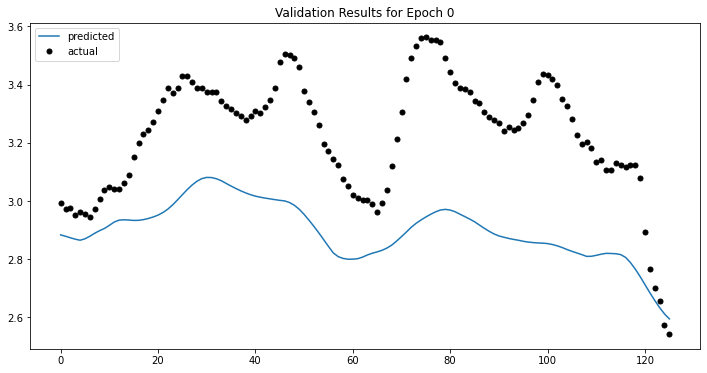

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.08645628301394342 val:  0.19356656758976207 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.06377646039906741 val:  0.1588791379799416 LR:  0.01
Validation loss decreased (0.019687 --> 0.016668).  Saving model ...
Iter:  3 train:  0.05569841885361768 val:  0.12910343373821365 LR:  0.01
Validation loss decreased (0.016668 --> 0.013933).  Saving model ...
Iter:  4 train:  0.048489843320415574 val:  0.1180382042922011 LR:  0.01
Validation loss decreased (0.013933 --> 0.011159).  Saving model ...
Iter:  5 train:  0.04372539949626689 val:  0.10563716646569607 LR:  0.01
Validation loss decreased (0.011159 --> 0.003872).  Saving model ...
Iter:  6 train:  0.03821810593428774 val:  0.06222726008872099 LR:  0.01
Validation loss decreased (0.003872 --> 0.003021).  Saving model ...
Iter:  7 train:  0.027808219604312557 val:  0.054960259781603196 LR:  0.01
Validation loss decreased (0.003021 --> 0.001146).  Saving model ...
Iter

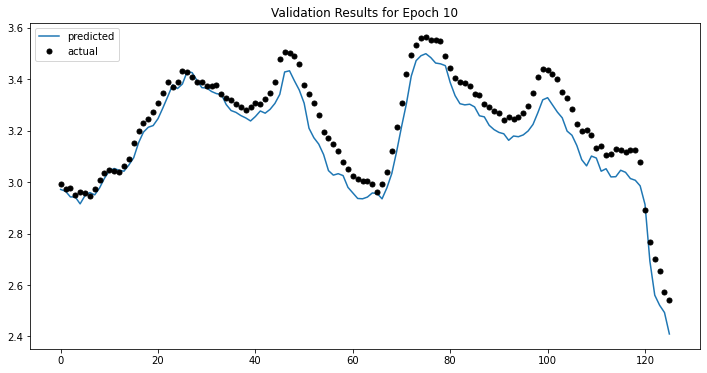

EarlyStopping counter: 1 out of 50
Iter:  11 train:  0.018282635911601026 val:  0.03167287595899146 LR:  0.01
Validation loss decreased (0.000878 --> 0.000829).  Saving model ...
Iter:  12 train:  0.01677177036976959 val:  0.02879643199573683 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  13 train:  0.018928340801590796 val:  0.02977860553288648 LR:  0.01
Validation loss decreased (0.000829 --> 0.000528).  Saving model ...
Iter:  14 train:  0.016102429498197277 val:  0.02298617021115702 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  15 train:  0.017470355785298607 val:  0.0365956245896054 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  16 train:  0.01728942893471097 val:  0.0350163566187939 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  17 train:  0.015307144966920611 val:  0.024506867878995243 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  18 train:  0.020395710475436833 val:  0.024831918421432345 LR:  0.01
Validation loss decreased (0.000528 --> 0.000159).  Sa

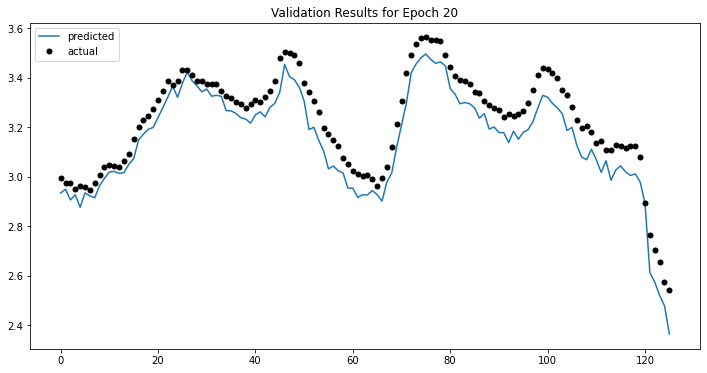

EarlyStopping counter: 2 out of 50
Iter:  21 train:  0.014989536348697164 val:  0.029555029518187514 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  22 train:  0.014655695688010735 val:  0.015699917385176294 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  23 train:  0.01747831282710583 val:  0.028962667201463458 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  24 train:  0.01784525317918694 val:  0.04037002209676377 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  25 train:  0.018025993620390507 val:  0.01787119658361405 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  26 train:  0.019525570943457145 val:  0.021651247191790807 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  27 train:  0.01622136420733861 val:  0.019267691360094368 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  28 train:  0.016806538803855433 val:  0.025401088244364795 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  29 train:  0.016103722718545196 val:  0.026476476654670057 LR:  0.01
Early

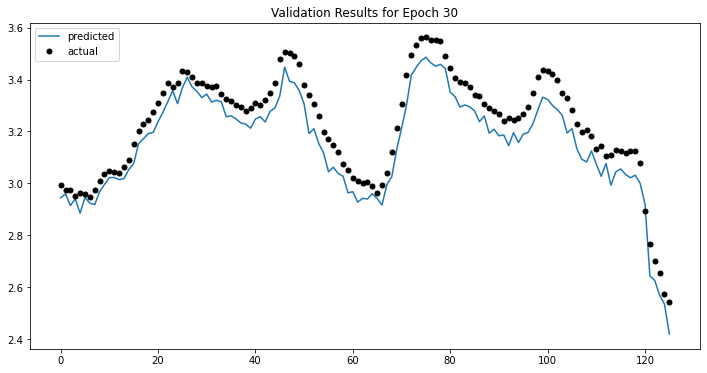

EarlyStopping counter: 12 out of 50
Iter:  31 train:  0.01616985271498772 val:  0.02820223940050046 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  32 train:  0.01857982124941146 val:  0.021287262413100264 LR:  0.01
Validation loss decreased (0.000159 --> 0.000138).  Saving model ...
Iter:  33 train:  0.017989769900940766 val:  0.011740307604809678 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  34 train:  0.01967804327637259 val:  0.02979501068134468 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  35 train:  0.015959567849815684 val:  0.039645361685946484 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  36 train:  0.015782012508970947 val:  0.024248588634379304 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  37 train:  0.01596808984974273 val:  0.01887595461253014 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  38 train:  0.014840092876044698 val:  0.020217144161863033 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  39 train:  0.01958498813091233 val:  0.03

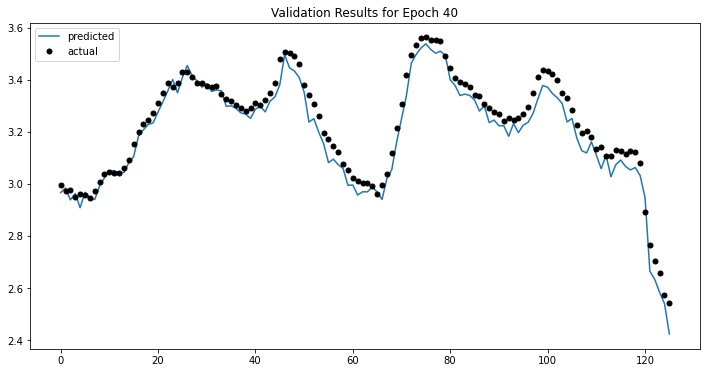

EarlyStopping counter: 8 out of 50
Iter:  41 train:  0.014926221603360334 val:  0.033939778874418326 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  42 train:  0.015685705351925747 val:  0.027234226736502103 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  43 train:  0.015703743137186987 val:  0.029412352896077625 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  44 train:  0.020083201551037076 val:  0.035275817241109224 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  45 train:  0.017223120034264638 val:  0.014045183307473612 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  46 train:  0.020850658079282325 val:  0.033019832897864816 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  47 train:  0.016759106530927215 val:  0.026903340235810456 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  48 train:  0.01637480225667267 val:  0.03749441687813943 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  49 train:  0.019137909462711246 val:  0.017795417454196417 LR:  0

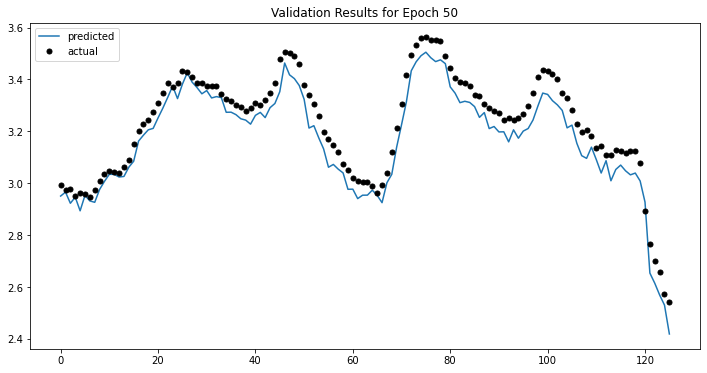

EarlyStopping counter: 18 out of 50
Iter:  51 train:  0.013887919331566096 val:  0.024581411237748343 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  52 train:  0.013638686960358295 val:  0.023938006771453475 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  53 train:  0.013807550075855208 val:  0.021139068618839397 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  54 train:  0.013589352656239947 val:  0.02091292682799368 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  55 train:  0.013687067625289292 val:  0.02197117579735587 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  56 train:  0.013705880423107435 val:  0.021101229400301503 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  57 train:  0.01360591998519297 val:  0.02076714549053958 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  58 train:  0.013533457581011554 val:  0.023379122265921804 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  59 train:  0.013601865699787061 val:  0.019691178652324 L

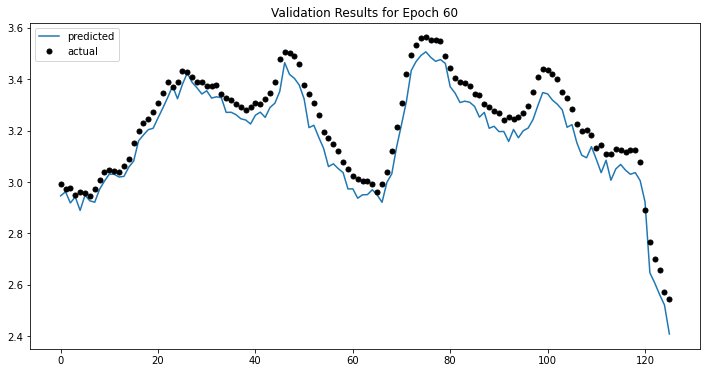

EarlyStopping counter: 28 out of 50
Iter:  61 train:  0.013803757485335657 val:  0.023507136270990367 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  62 train:  0.013728630842688036 val:  0.019472612477360988 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  63 train:  0.013692716470086961 val:  0.022827626564854098 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  64 train:  0.013527455365606234 val:  0.02511303331693741 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  65 train:  0.013862328284011016 val:  0.02105787042049777 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  66 train:  0.013399123770159746 val:  0.021053006203200435 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  67 train:  0.0133651546545744 val:  0.02163705723941977 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  68 train:  0.01337958797842351 val:  0.021306733297173603 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  69 train:  0.013361941428197665 val:  0.020847495776369

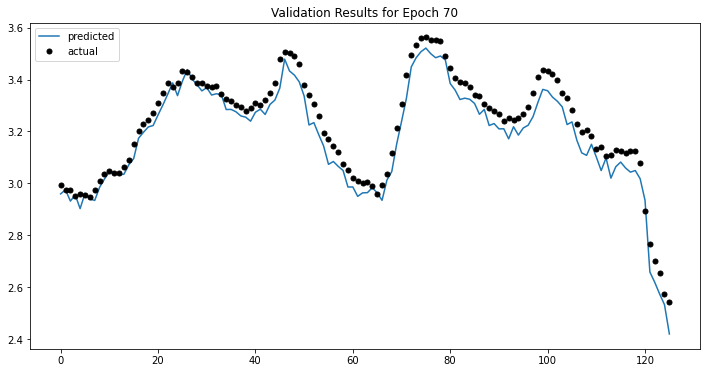

EarlyStopping counter: 38 out of 50
Iter:  71 train:  0.01332298374217917 val:  0.021067732687512577 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  72 train:  0.013342157780866065 val:  0.020991425212574553 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  73 train:  0.013330840655991957 val:  0.02208375350951468 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  74 train:  0.013335077227031818 val:  0.02159113207048566 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  75 train:  0.013357027378188611 val:  0.022216433401177023 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  76 train:  0.013338266014483978 val:  0.02185494200714989 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  77 train:  0.013340843475658726 val:  0.021894639515324502 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  78 train:  0.013368130739456863 val:  0.022387608817864266 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  79 train:  0.013336889738548264 val:  0.021655488

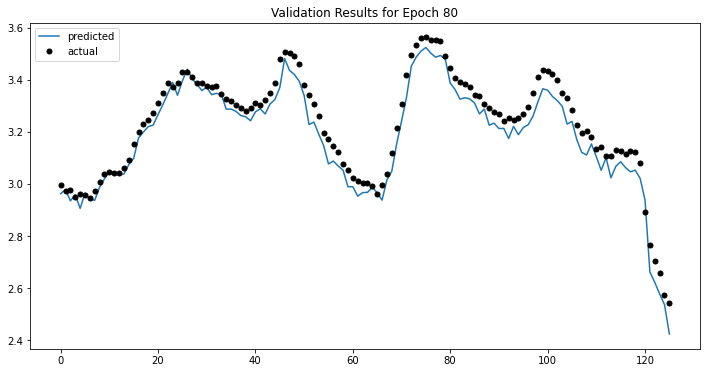

EarlyStopping counter: 48 out of 50
Iter:  81 train:  0.013418844185619339 val:  0.02235501357507533 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  82 train:  0.013329856786442596 val:  0.022036359440362 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [54]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [55]:
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

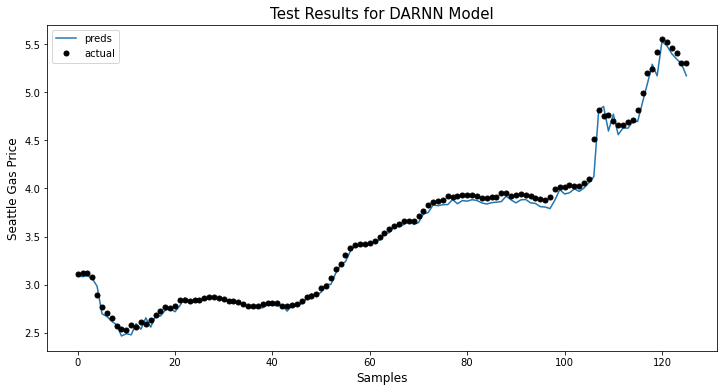

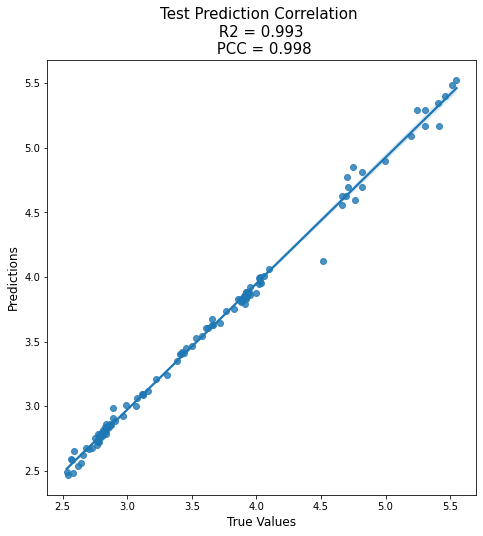

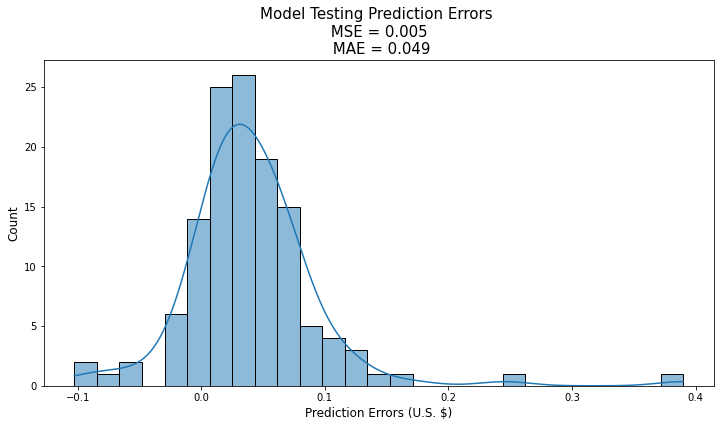

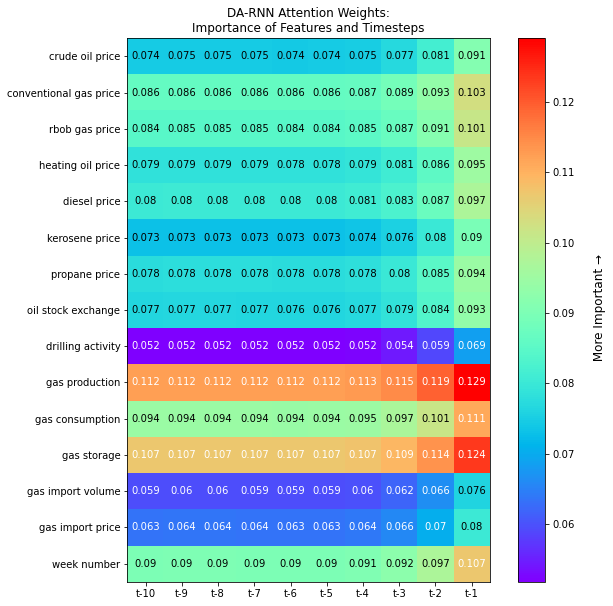

In [140]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true, darnn_alphas, darnn_betas = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

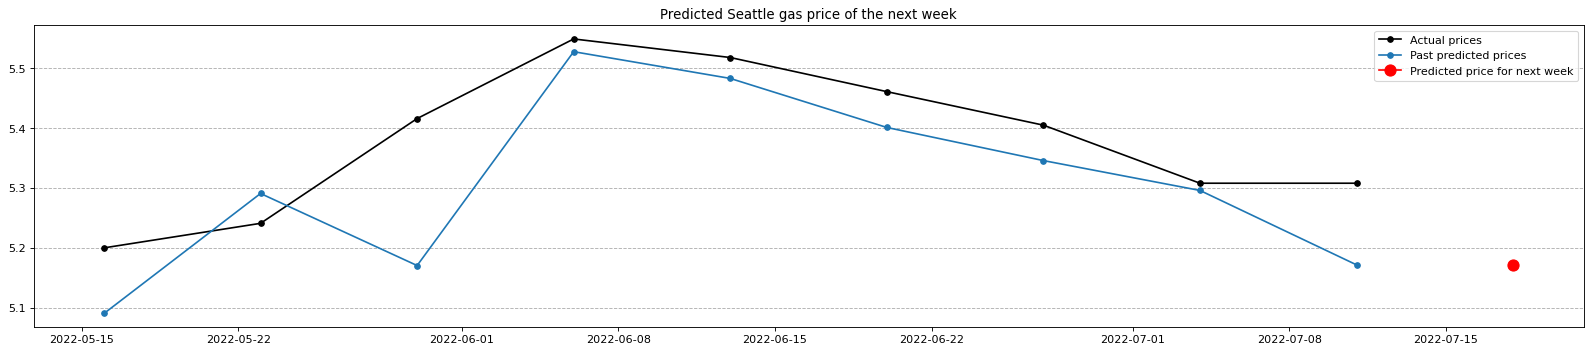

DARNN Predicted Seattle Gas Price of the next week: $5.17


In [57]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

# 8. Model Comparison